In [1]:
import os
import sys

sys.path.append(os.path.join("..",".."))
sys.path.append(os.path.join("..","..","..",'Data_prep'))
#sys.path.append(os.path.join(".."))

import numpy as np

import pickle
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from Utils import *

In [7]:
!ls ../VAE_v2_2	

bce_results.npy  best1.pt  kld_results.npy     loss_results.npy
best0.pt	 desc.txt  Load_results.ipynb


In [2]:
#import Utils_imp_VAE
from B_VAE.VAE_v2 import b_encodeco

In [3]:
res_dir=os.path.join("..",'VAE_v2_2')

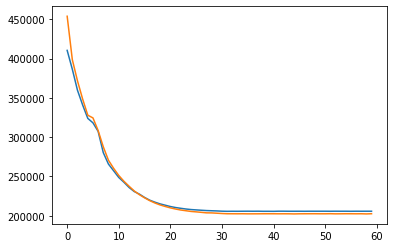

In [4]:
train,test=read_results(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True),0)
train1,test1=read_results(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

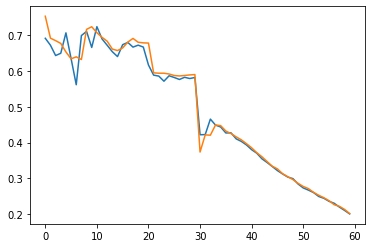

In [5]:
train,test=read_results(np.load(os.path.join(res_dir,'kld_results.npy'),allow_pickle=True),0)
train1,test1=read_results(np.load(os.path.join(res_dir,'kld_results.npy'),allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

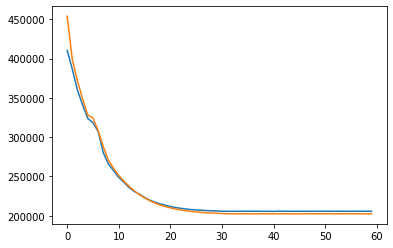

In [6]:
train,test=read_results(np.load(os.path.join(res_dir,'loss_results.npy'),allow_pickle=True),0)
train1,test1=read_results(np.load(os.path.join(res_dir,'loss_results.npy'),allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

In [8]:
#a=torch.load('best1.pt')
a=torch.load(os.path.join(res_dir,'best1.pt'))

In [9]:
model=b_encodeco(image_dim=int(100),
                 image_channels=3,
                 repr_sizes=[5,8,10],
                 layer_sizes=[100],
                 latent_space_size=20,
                 conv_kernel_size=15,
                 conv_pooling=False,
                 conv_batch_norm=True,
                 NN_batch_norm=True,
                 stride=2,
                device='cuda')

In [10]:
model.load_state_dict(a)

<All keys matched successfully>

In [11]:
model.eval()

b_encodeco(
  (encoder_conv): b_encoder_conv(
    (im_layers): ModuleList(
      (0): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(3, 5, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(5, 8, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(8, 10, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
  )
  (encoder_NN_mu): NeuralNet(
    (layers): ModuleList(
      (0): Sequential(
        (0): NN_layer(
          (layer): ModuleList(
            (0): L

In [12]:
from torchvision import transforms
from Custom_dataloader import *
from Transforms import phantom_segmentation
from Transforms import phantom_segmentation_
from Transforms import multi_image_resize
from Transforms import multi_ToTensor
from Transforms import output_transform
from Transforms import rgb_normalize

DB="/run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=aorus_1,volume=Paltas_DataBase/Data_Base_v2"

d_tt=transforms.Compose([
        phantom_segmentation_(False),
        rgb_normalize(ImType=['PhantomRGB']),
        multi_image_resize(ImType=['PhantomRGB'],size=(100,100)),
        multi_ToTensor(ImType=['PhantomRGB']),
        #output_transform()
        ])

datab=Dataset_direct(root_dir=DB,ImType=['PhantomRGB'],Intersec=False,transform=d_tt)

In [10]:
img=datab[100]

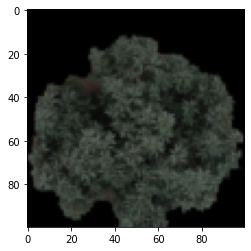

In [30]:
i=img['PhantomRGB']
ir=np.dstack([i[0,:,:],i[1,:,:],i[2,:,:]])
plt.imshow(ir)

In [11]:
print(model.encoder_conv.im_layers)
model.to('cpu')
fl=model.encoder_conv(torch.unsqueeze(img['PhantomRGB'], 0))
fl_=model.flatten(fl)
fl_u=model.encoder_NN_mu(fl_)
fl_sig=model.encoder_NN_sig(fl_)

ModuleList(
  (0): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(3, 5, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(5, 8, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(8, 10, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)


0


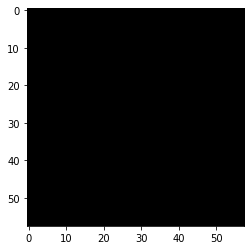

1


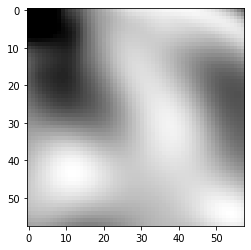

2


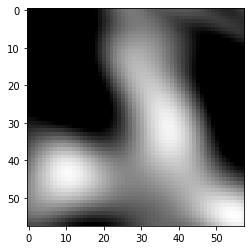

3


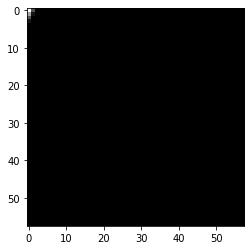

4


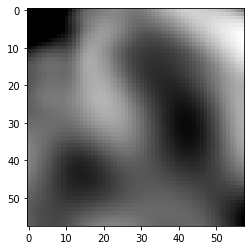

5


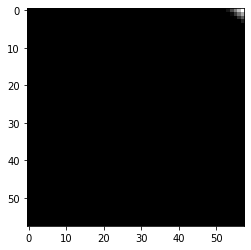

6


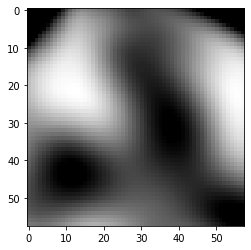

7


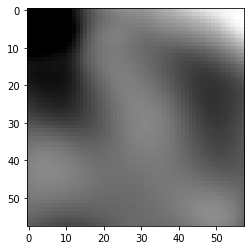

8


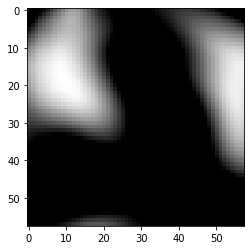

9


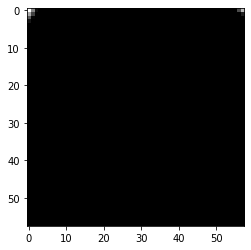

In [12]:
for i in range(10):
    print(i)
    plt.imshow(fl[0,i,:,:].detach().numpy(),cmap='gray')
    plt.show()
#plt.imshow(fl[0,0,:,:].detach().numpy())
#fl[0,0,:,:].detach().numpy().shape

In [33]:
model.to('cuda')
io=model(torch.unsqueeze(img['PhantomRGB'], 0).to('cuda'))

In [34]:
io=io[0].to('cpu').detach().numpy()

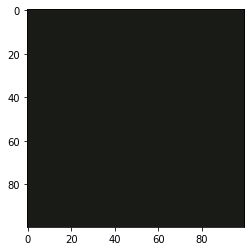

In [35]:
io=io[0,:,:,:]
ir=np.dstack([io[0,:,:],io[1,:,:],io[2,:,:]])
plt.imshow(ir)

In [36]:
model.to('cpu')
fl=model.encoder_conv(torch.unsqueeze(img['PhantomRGB'], 0))
fl_=model.flatten(fl)
fl_u=model.encoder_NN_mu(fl_)
fl_sig=model.encoder_NN_sig(fl_)

array([[0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       ...,
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854]], dtype=float32)

In [2]:
meta_dir="/run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=aorus_1,volume=Paltas_DataBase/metadata_VAE_v2"

In [3]:
metad=np.array(os.listdir(meta_dir)[1:])

In [4]:
metad_dict=np.vectorize(lambda meta: pickle.load(open(os.path.join(meta_dir,meta),'rb')))(metad)

In [5]:
meta_u=np.vectorize(lambda dic:dic['u'],signature='()->(j)')(metad_dict)
meta_sig=np.vectorize(lambda dic:dic['sig'],signature='()->(j)')(metad_dict)
meta_C=np.vectorize(lambda dic:dic['Class'][0],otypes=[object],signature='()->()')(metad_dict)

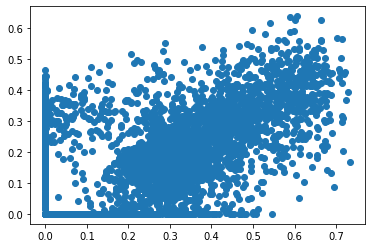

In [6]:
plt.scatter(meta_sig[:,3],meta_sig[:,11])

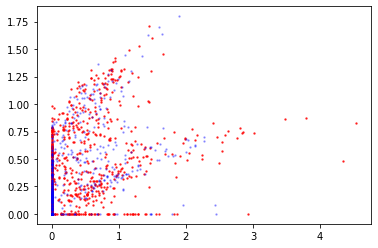

In [7]:
plt.scatter(meta_u[meta_C=='Control',11],meta_u[meta_C=='Control',-1],color='r',alpha=0.7,s=2)
plt.scatter(meta_u[meta_C=='H50%',11],meta_u[meta_C=='H50%',-1],color='b',alpha=0.3,s=2)

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [12]:
pca = PCA(n_components=2)
pca.fit(meta_u)
meta_u_p=pca.transform(meta_u)

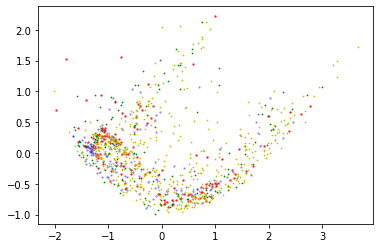

In [31]:
plt.scatter(meta_u_p[meta_C=='N_Deficiencia',0],meta_u_p[meta_C=='N_Deficiencia',1],color='b',alpha=0.3,s=2)
plt.scatter(meta_u_p[meta_C=='N_Control',0],meta_u_p[meta_C=='N_Control',1],color='r',alpha=0.7,s=2)
plt.scatter(meta_u_p[meta_C=='N_Exceso',0],meta_u_p[meta_C=='N_Exceso',1],color='g',alpha=1.,s=0.5)
plt.scatter(meta_u_p[meta_C=='H50%',0],meta_u_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)

In [19]:
pca = PCA(n_components=2)
pca.fit(meta_sig)
meta_sig_p=pca.transform(meta_sig)

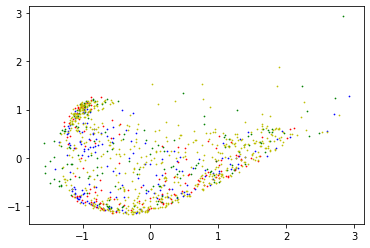

In [27]:
plt.scatter(meta_sig_p[meta_C=='N_Deficiencia',0],meta_sig_p[meta_C=='N_Deficiencia',1],color='b',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='N_Control',0],meta_sig_p[meta_C=='N_Control',1],color='r',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='N_Exceso',0],meta_sig_p[meta_C=='N_Exceso',1],color='g',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='H50%',0],meta_sig_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)

In [36]:
pca = TSNE(n_components=2)
meta_sig_p=pca.fit_transform(meta_sig)

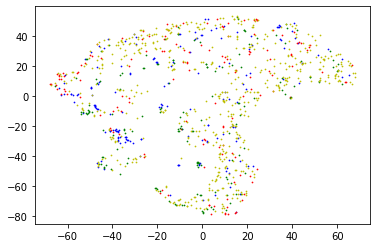

In [38]:
plt.scatter(meta_sig_p[meta_C=='N_Deficiencia',0],meta_sig_p[meta_C=='N_Deficiencia',1],color='b',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='N_Control',0],meta_sig_p[meta_C=='N_Control',1],color='r',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='N_Exceso',0],meta_sig_p[meta_C=='N_Exceso',1],color='g',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='H50%',0],meta_sig_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)

In [39]:
pca = TSNE(n_components=2)
meta_u_p=pca.fit_transform(meta_u)

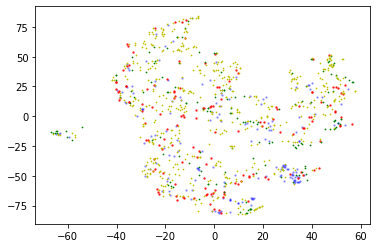

In [40]:
plt.scatter(meta_u_p[meta_C=='N_Deficiencia',0],meta_u_p[meta_C=='N_Deficiencia',1],color='b',alpha=0.3,s=2)
plt.scatter(meta_u_p[meta_C=='N_Control',0],meta_u_p[meta_C=='N_Control',1],color='r',alpha=0.7,s=2)
plt.scatter(meta_u_p[meta_C=='N_Exceso',0],meta_u_p[meta_C=='N_Exceso',1],color='g',alpha=1.,s=0.5)
plt.scatter(meta_u_p[meta_C=='H50%',0],meta_u_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)

In [44]:
pca = TSNE(n_components=2)
meta_a_p=pca.fit_transform(np.hstack((meta_u,meta_sig)))

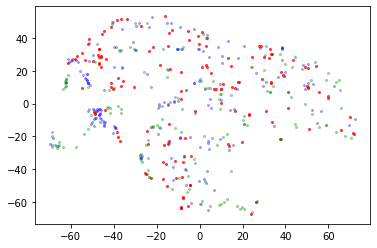

In [50]:
plt.scatter(meta_a_p[meta_C=='N_Deficiencia',0],meta_a_p[meta_C=='N_Deficiencia',1],color='b',alpha=0.3,s=4.2)
plt.scatter(meta_a_p[meta_C=='N_Control',0],meta_a_p[meta_C=='N_Control',1],color='r',alpha=0.7,s=4.2)
plt.scatter(meta_a_p[meta_C=='N_Exceso',0],meta_a_p[meta_C=='N_Exceso',1],color='g',alpha=.3,s=4.5)
#plt.scatter(meta_a_p[meta_C=='H50%',0],meta_a_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)
#plt.scatter(meta_a_p[meta_C=='Control',0],meta_a_p[meta_C=='Control',1],color='k',alpha=1.,s=0.5)